### Shawn Trewartha
### May 31, 2025

**Note for the reader:**  
While I initially intended to model pitch location as well as pitch type, I found that pitch location was a poor target variable for reasons explained in the notebook below. If you’d like to jump ahead to the model construction for pitch type — which is what I ultimately used for the presentation — look for the section titled **Pitch Type Predictive Model**. Thank you.

# Problem Identification:
Baseball is not only a game of strength and technique, but also one of strategy and misdirection. Pitchers are constantly thinking several pitches ahead, planning ideal pitch sequences to confuse the batter and ultimately rack up strikeouts. The goal is to make each sequence of pitches as unpredictable as possible, and this is often successful — hitters are frequently forced to guess at the type of pitch coming their way.

I believe that with the right machine learning techniques — specifically, a sequence-to-vector LSTM model — it is possible to uncover patterns in pitch selection, whether intentional or unintentional. This could allow us to build a predictive pitch model that can be studied to give hitters a much better idea of what pitch might be thrown at any point during a game.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

train_path = "/content/drive/MyDrive/Machine Learning 2/Final/MLB_dataset/train.csv"
train_df = pd.read_csv(train_path)

start_date = 20190401
end_date = 20190930
df_filtered = train_df[(train_df['date'] >= start_date) & (train_df['date'] <= end_date)]

row = df_filtered[df_filtered['events'].notnull()].iloc[0]

Mounted at /content/drive


### Data Cleaning Step 1
Filter the dataset to include only the **'Events'** data, which contains all of the pitches thrown during the 2019 season.

In [ ]:
import json

events = json.loads(row['events'])
events_df = pd.DataFrame(events)

# Initialize an empty list to store all events
all_events = []

# Loop through each row in the dataset (for the whole month)
for index, row in df_filtered.iterrows():
    # Only process rows with non-null events
    if pd.notnull(row['events']):
        events = json.loads(row['events'])  # Parse the JSON data
        all_events.extend(events)  # Add the events to the list

# Convert the list of events to a DataFrame
events_df = pd.DataFrame(all_events)

events_df.columns

Index(['gamePk', 'gameDate', 'gameTimeUTC', 'season', 'gameType', 'playId',
       'eventId', 'inning', 'halfInning', 'homeScore', 'awayScore',
       'menOnBase', 'atBatIndex', 'atBatDesc', 'atBatEvent', 'hasOut',
       'pitcherTeamId', 'isPitcherHome', 'pitcherTeam', 'hitterTeamId',
       'hitterTeam', 'pitcherId', 'pitcherName', 'isStarter', 'pitcherHand',
       'hitterId', 'hitterName', 'batSide', 'pitchNumber', 'balls', 'strikes',
       'isGB', 'isLD', 'isFB', 'isPU', 'launchSpeed', 'launchAngle',
       'totalDistance', 'event', 'description', 'rbi', 'pitchType', 'call',
       'outs', 'inPlay', 'isPaOver', 'startSpeed', 'endSpeed', 'nastyFactor',
       'breakAngle', 'breakLength', 'breakY', 'spinRate', 'spinDirection',
       'pX', 'pZ', 'aX', 'aY', 'aZ', 'pfxX', 'pfxZ', 'vX0', 'vY0', 'vZ0', 'x',
       'y', 'x0', 'y0', 'z0', 'type', 'zone'],
      dtype='object')

### Data Cleaning step 2
Further narrow down the dataset by selecting only the most relevant columns needed for analysis and modeling.

In [ ]:
# Only Use select columns

columns = ['gamePk', 'atBatIndex', 'pitcherId', 'hitterId', 'batSide', 'pitchNumber', 'balls', 'strikes',
           'pitchType', 'type', 'zone']

events_select = events_df[columns]

In [ ]:
## Only select events where type = pitch

events_pitch = events_select[events_select['type'] == 'pitch']

events_pitch

,gamePk,atBatIndex,pitcherId,hitterId,batSide,pitchNumber,balls,strikes,pitchType,type,zone
298,565316,62,592229,467793,L,1,1,0,None,pitch,NaN
299,566180,78,553878,500874,R,1,1,0,CH,pitch,13.0
300,566668,32,642232,435622,R,2,2,0,CH,pitch,13.0
301,567157,51,445213,542255,L,1,1,0,CH,pitch,11.0
302,567157,48,543294,435263,L,2,2,0,None,pitch,NaN
...,...,...,...,...,...,...,...,...,...,...,...
777158,566647,60,606149,663538,R,6,1,2,FF,pitch,13.0
777159,567139,6,645261,656555,R,7,3,2,SI,pitch,7.0
777160,565107,24,605469,593428,R,4,1,2,CU,pitch,4.0
777161,567139,62,453172,445988,R,8,3,3,CU,pitch,6.0


### Data Cleaning Step 3
Create a unique **‘At Bat’** identifier by combining the Game ID and the At Bat index.

In [ ]:
# combine gamePk and atBatIndex and pitchNumber

events_pitch['at_bat'] = (
    events_pitch['gamePk'].astype(str) + '_' +
    events_pitch['atBatIndex'].astype(str)
)

events_pitch = events_pitch.sort_values(by=['at_bat', 'pitchNumber'])

<ipython-input-6-e7b51687a4c2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_pitch['at_bat'] = (


### Data Cleaning Step 4
Create a target variable that combines both pitch type and pitch location to represent each pitch more comprehensively.

In [ ]:
# Combine pitchType and Zone to a new column

events_pitch['pitch_zone'] = events_pitch['pitchType'] + '_' + events_pitch['zone'].astype(str)

In [ ]:
events_pitch.dtypes

,0
gamePk,int64
atBatIndex,int64
pitcherId,int64
hitterId,int64
batSide,object
pitchNumber,int64
balls,int64
strikes,int64
pitchType,object
type,object


### Data Cleaning Step 5

**Target Engineering:**  
The dataset contains very specific pitch types, that can muddy the waters when modeling. However, for practical purposes, several of these can be grouped into broader pitch type categories:

* Fastball (Four seamers and Two seamers)
* Breaking Fastballs (Sinkers and Cutters)
* Sliders
* Curveballs (Curveballs, Knuckle Curves, and Eephus pitches)
* Changeups (Changeup, Forkballs, Spliters)
* Other (Knuckleballs)

In [ ]:
pitch_type_map = {
    'FF': 'Fastball',
    'FT': 'Fastball',
    'SI': 'Breaking_Fastball',
    'FC': 'Breaking_Fastball',
    'SL': 'Slider',
    'CU': 'Curveball',
    'KC': 'Curveball',
    'EP': 'Curveball',
    'CH': 'Changeup',
    'FO': 'Changeup',
    'FS': 'Changeup',
    'KN': 'Other',
    '': 'Other'
}

events_pitch['pitchType_general'] = events_pitch['pitchType'].map(pitch_type_map)
events_pitch['pitchType_general'] = events_pitch['pitchType_general'].fillna('Other')

### Data Cleaning Step 6

Use a LabelEncoder to convert all categorical variables into numerical format for model compatibility.

In [ ]:
# Encode the data appropriatly

from sklearn.preprocessing import LabelEncoder

type_encoder = LabelEncoder()
type_enc = type_encoder.fit_transform(events_pitch['pitchType_general'])

zone_encoder = LabelEncoder()
y_zone= zone_encoder.fit_transform(events_pitch['zone'])

pitch_zone_encoder = LabelEncoder()
pitch_zone_enc = pitch_zone_encoder.fit_transform(events_pitch['pitch_zone'])

pitcher_encoder = LabelEncoder()
pitcher_enc = pitcher_encoder.fit_transform(events_pitch['pitcherId'])

hitter_encoder = LabelEncoder()
hitter_enc = hitter_encoder.fit_transform(events_pitch['hitterId'])

at_bat_encoder = LabelEncoder()
at_bat_enc = at_bat_encoder.fit_transform(events_pitch['at_bat'])

bat_side_encoder = LabelEncoder()
batside_enc = bat_side_encoder.fit_transform(events_pitch['batSide'])

events_pitch['pitcherId_enc'] = pitcher_enc
events_pitch['hitterId_enc'] = hitter_enc
events_pitch['batSide_enc'] = batside_enc
events_pitch['type_enc'] = type_enc
events_pitch['zone_enc'] = y_zone
events_pitch['pitch_zone_enc'] = pitch_zone_enc

In [ ]:
events_pitch_grouped = events_pitch.groupby('at_bat')

events_pitch_grouped.head()

,gamePk,atBatIndex,pitcherId,hitterId,batSide,pitchNumber,balls,strikes,pitchType,type,zone,at_bat,pitch_zone,pitchType_general,pitcherId_enc,hitterId_enc,batSide_enc,type_enc,zone_enc,pitch_zone_enc
13318,564734,0,518774,425783,L,1,0,1,FF,pitch,6.0,564734_0,FF_6.0,Fastball,162,4,0,3,5,61
14096,564734,0,518774,425783,L,2,1,1,SL,pitch,14.0,564734_0,SL_14.0,Slider,162,4,0,5,12,148
13923,564734,0,518774,425783,L,3,2,1,FF,pitch,14.0,564734_0,FF_14.0,Fastball,162,4,0,3,12,56
14009,564734,0,518774,425783,L,4,2,2,FF,pitch,3.0,564734_0,FF_3.0,Fastball,162,4,0,3,2,58
15137,564734,0,518774,425783,L,5,3,2,SL,pitch,14.0,564734_0,SL_14.0,Slider,162,4,0,5,12,148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742652,567632,9,605540,622569,R,1,0,1,FT,pitch,1.0,567632_9,FT_1.0,Fastball,469,693,1,3,0,90
744108,567632,9,605540,622569,R,2,1,1,FT,pitch,11.0,567632_9,FT_11.0,Fastball,469,693,1,3,9,91
744079,567632,9,605540,622569,R,3,1,2,SL,pitch,3.0,567632_9,SL_3.0,Slider,469,693,1,5,2,150
743712,567632,9,605540,622569,R,4,1,2,FF,pitch,5.0,567632_9,FF_5.0,Fastball,469,693,1,3,4,60


# Model Development:

### Create the sequences required for LSTM models

Determine the length of the longest at-bat pitch sequence. This value will be used to define the maximum sequence length and ensure consistent input shape by applying padding to all shorter sequences.

In [ ]:
max_len = events_pitch['pitchNumber'].max()

max_len

16

Construct the input features as sequences of pitches, ensuring the chronological order of pitches within each at-bat is properly maintained. Include the previous pitch type and pitch location as additional features to provide necessary context.

Also, Identify three different target variables — pitch type, pitch location, and a combination of both — which will be tested independently to evaluate their predictive performance.

In [ ]:
# Set Features and Target Variables
## Add Previous Pitch location as a feature

feature_cols = ['pitcherId_enc', 'hitterId_enc', 'balls', 'strikes', 'batSide_enc']

X_seq = []
y_zone = []
y_pitch_zone = []
y_pitch = []

for at_bat, group in events_pitch_grouped:
    group = group.sort_values('pitchNumber')
    features = group[feature_cols].astype('float32').values
    pitch_types = group['type_enc'].values.astype('float32').reshape(-1, 1)
    pitch_location = group['zone_enc'].values.astype('float32').reshape(-1, 1)
    targets_type = group['type_enc'].values
    targets_zone = group['zone_enc'].values
    targets_pitch_zone = group['pitch_zone_enc'].values

    features = np.hstack([features, pitch_types, pitch_location])

    # generate one (input, target) pair for each step except the last
    for i in range(1, len(group)):
        X_seq.append(features[:i].tolist())
        y_pitch.append(targets_type[i])
        y_zone.append(targets_zone[i])
        y_pitch_zone.append(targets_pitch_zone[i])


    if len(group) == 1:
        X_seq.append(features.tolist())  # Ensure it's a list even for single pitch
        y_pitch.append(targets_type[0])
        y_zone.append(targets_zone[0])
        y_pitch_zone.append(targets_pitch_zone[0])

In [ ]:
X_seq_padded = pad_sequences(X_seq, maxlen=max_len, padding='post', dtype='float32')
y_pitch = np.array(y_pitch)
y_zone = np.array(y_zone)
y_pitch_zone = np.array(y_pitch_zone)

print(X_seq_padded.shape)
print(y_pitch.shape)
print(y_zone.shape)
print(y_pitch_zone.shape)

(556190, 16, 7)
(556190,)
(556190,)
(556190,)


In [ ]:
print(X_seq_padded[0])
print(y_pitch[0])
print(y_zone[0])
print(y_pitch_zone[0])

[[162.   4.   0.   1.   0.   3.   5.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]]
5
12
148


Create separate training and testing datasets for each of the three target variables. Use the train-test split method to ensure that pitch type, pitch location, and the combined pitch type-location targets are all prepared independently for model training and evaluation.

In [ ]:
X_pitch_train, X_pitch_test, y_pitch_train, y_pitch_test = train_test_split(X_seq_padded, y_pitch, test_size=0.2, random_state=123)
X_zone_train, X_zone_test, y_zone_train, y_zone_test = train_test_split(X_seq_padded, y_zone, test_size=0.2, random_state=456)
X_zonepitch_train, X_zonepitch_test, y_zonepitch_train, y_zonepitch_test = train_test_split(X_seq_padded, y_pitch_zone, test_size=0.2, random_state=456)

# Construct LSTM Model for Pitch Location Prediction

In [ ]:
num_pitch_zone = len(np.unique(y_zone_train))

zone_lstm_2 = models.Sequential([
    layers.LSTM(64, activation = 'tanh', return_sequences=True, input_shape =(X_zone_train.shape[1], 7)),
    layers.LSTM(32, activation = 'tanh'),
    layers.Dense(num_pitch_zone, activation= 'softmax')
])

zone_lstm_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_zone_train),
    y=y_zone_train
)

class_weights = dict(enumerate(class_weights))


early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


history_zone_lstm_2 = zone_lstm_2.fit(
    X_zone_train,
    y_zone_train,
    epochs=100, batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weights,
    validation_split=0.2)

Epoch 1/100
11124/11124 ━━━━━━━━━━━━━━━━━━━━ 80s 7ms/step - accuracy: 0.0521 - loss: 2.6410 - val_accuracy: 0.0298 - val_loss: 2.6296
Epoch 2/100
11124/11124 ━━━━━━━━━━━━━━━━━━━━ 79s 7ms/step - accuracy: 0.0608 - loss: 2.6233 - val_accuracy: 0.0656 - val_loss: 2.6241
Epoch 3/100
11124/11124 ━━━━━━━━━━━━━━━━━━━━ 79s 7ms/step - accuracy: 0.0590 - loss: 2.6119 - val_accuracy: 0.0687 - val_loss: 2.6118
Epoch 4/100
11124/11124 ━━━━━━━━━━━━━━━━━━━━ 79s 7ms/step - accuracy: 0.0696 - loss: 2.5874 - val_accuracy: 0.0813 - val_loss: 2.5972
Epoch 5/100
11124/11124 ━━━━━━━━━━━━━━━━━━━━ 78s 7ms/step - accuracy: 0.0744 - loss: 2.5621 - val_accuracy: 0.0740 - val_loss: 2.5792
Epoch 6/100
11124/11124 ━━━━━━━━━━━━━━━━━━━━ 78s 7ms/step - accuracy: 0.0762 - loss: 2.5427 - val_accuracy: 0.0679 - val_loss: 2.5878
Epoch 7/100
11124/11124 ━━━━━━━━━━━━━━━━━━━━ 78s 7ms/step - accuracy: 0.0792 - loss: 2.5281 - val_accuracy: 0.0649 - val_loss: 2.6003
Epoch 8/100
11124/11124 ━━━━━━━━━━━━━━━━━━━━ 79s 7ms/step - ac

Plot the training and validation loss

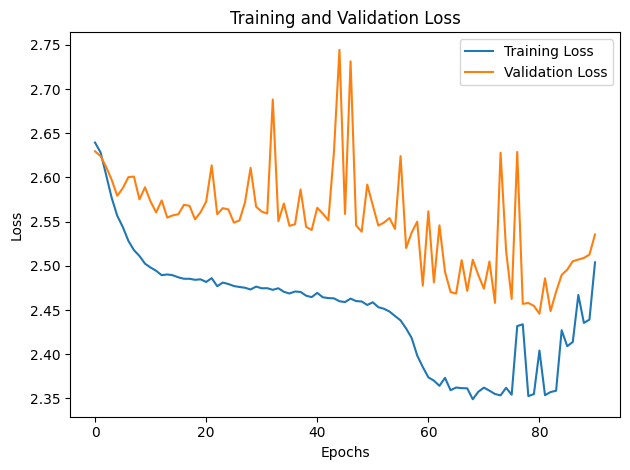

In [ ]:
plt.plot(history_zone_lstm_2.history['loss'], label='Training Loss')
plt.plot(history_zone_lstm_2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation

In [ ]:
y_zone_pred_lstm2 = zone_lstm_2.predict(X_zone_test)

y_pred_classes_zone2 = np.argmax(y_zone_pred_lstm2, axis=1)
acc_zone2 = accuracy_score(y_zone_test, y_pred_classes_zone2)
print(f"Accuracy: {acc_zone2:.2f}")

3477/3477 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
Accuracy: 0.16


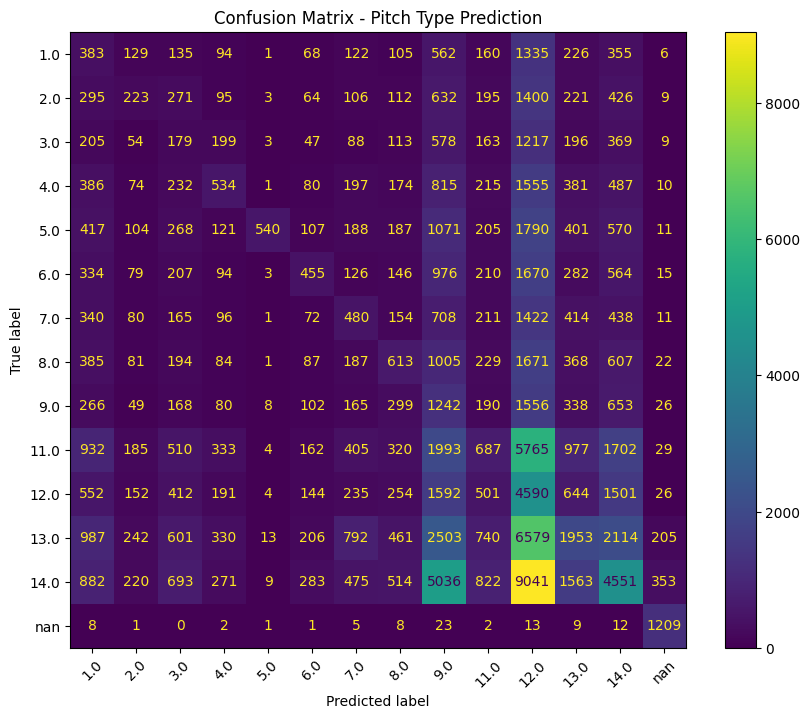

In [ ]:
cm_zone2 = confusion_matrix(y_zone_test, y_pred_classes_zone2)

fig, ax = plt.subplots(figsize=(10, 8))

disp = ConfusionMatrixDisplay(confusion_matrix=cm_zone2, display_labels=zone_encoder.classes_)
disp.plot(ax=ax, xticks_rotation=45)

plt.title("Confusion Matrix - Pitch Type Prediction")
plt.show()

**Conclusion of Pitch Location Analysis**

> Adding class weight adjustments didn’t significantly improve the overall accuracy of the model. It still struggled to predict pitch locations accurately and instead created a new bias toward the second most common location — low and inside to a right-handed batter.

> I no longer believe that pitch location is an adequate target variable for modeling with LSTM or RNN architectures. The core issue is that we're not working in a perfect scenario — pitchers miss their intended spots quite often. For example, a pitch that was meant to be high and inside could easily end up low and away. In other words, by using pitch location as the target, we’re trying to predict the outcome of a pitch, when what we should be modeling is the intent behind it.

> While pitch location depends on a high level of execution and is difficult to model reliably, I believe pitch type is a more appropriate and stable target. Even a poorly thrown changeup will still be recorded as a changeup, regardless of its result — and that’s the kind of information we're truly after. For this reason, I’ll continue modeling pitch type and set aside pitch location as a target variable for now.

# ------------------------------------------------------------------------------
# Pitch Type Predictive Model
# ------------------------------------------------------------------------------

# Model Development:

# Construct LSTM Model for Pitch Type Prediction - Attempt #1

In [ ]:
num_pitch_types = len(np.unique(y_pitch_train))

pitch_lstm_6 = models.Sequential([
    layers.LSTM(64, activation = 'tanh', return_sequences=True, input_shape =(X_pitch_train.shape[1], 7)),
    layers.Dropout(0.2),
    layers.LSTM(32, activation = 'tanh', return_sequences=True),
    layers.LSTM(32, activation = 'tanh'),
    layers.Dense(num_pitch_types, activation= 'softmax')
])

pitch_lstm_6.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_pitch_train),
    y=y_pitch_train
)

class_weights = dict(enumerate(class_weights))


early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


history_pitch_lstm_6 = pitch_lstm_6.fit(
    X_pitch_train,
    y_pitch_train,
    epochs=100, batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weights,
    validation_split=0.2)

Epoch 1/100
11124/11124 ━━━━━━━━━━━━━━━━━━━━ 94s 8ms/step - accuracy: 0.1758 - loss: 1.7834 - val_accuracy: 0.1476 - val_loss: 1.7453
Epoch 2/100
11124/11124 ━━━━━━━━━━━━━━━━━━━━ 90s 8ms/step - accuracy: 0.1320 - loss: 1.7124 - val_accuracy: 0.1988 - val_loss: 1.6564
Epoch 3/100
11124/11124 ━━━━━━━━━━━━━━━━━━━━ 90s 8ms/step - accuracy: 0.2065 - loss: 1.5640 - val_accuracy: 0.2308 - val_loss: 1.6448
Epoch 4/100
11124/11124 ━━━━━━━━━━━━━━━━━━━━ 90s 8ms/step - accuracy: 0.2389 - loss: 1.4732 - val_accuracy: 0.2513 - val_loss: 1.5980
Epoch 5/100
11124/11124 ━━━━━━━━━━━━━━━━━━━━ 90s 8ms/step - accuracy: 0.2634 - loss: 1.4411 - val_accuracy: 0.2543 - val_loss: 1.5369
Epoch 6/100
11124/11124 ━━━━━━━━━━━━━━━━━━━━ 90s 8ms/step - accuracy: 0.2999 - loss: 1.3843 - val_accuracy: 0.3269 - val_loss: 1.4629
Epoch 7/100
11124/11124 ━━━━━━━━━━━━━━━━━━━━ 90s 8ms/step - accuracy: 0.2992 - loss: 1.3709 - val_accuracy: 0.3383 - val_loss: 1.4596
Epoch 8/100
11124/11124 ━━━━━━━━━━━━━━━━━━━━ 90s 8ms/step - ac

# Evaluation

Plot the training and validation loss

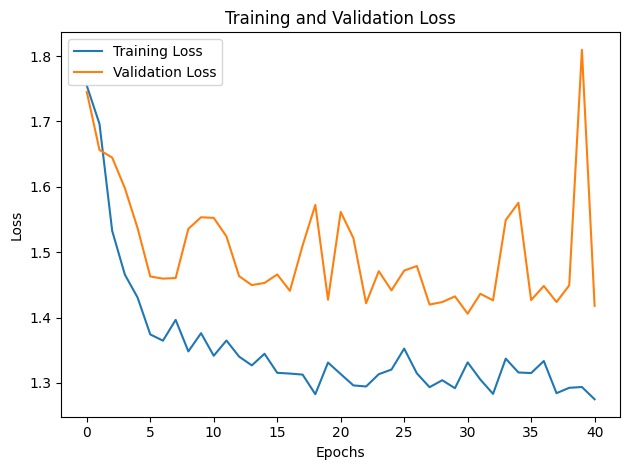

In [ ]:
plt.plot(history_pitch_lstm_6.history['loss'], label='Training Loss')
plt.plot(history_pitch_lstm_6.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

> This plot shows training loss and validation loss curves that are more in line with the expectations. Both decrease rapidly for the first handful of epochs, then begin to level off and fluctuate as gradual descent attempts to converge the model to the minimum. Finally, the early stop halts the model training after 40 epochs. Because the curves don’t begin to trend upwards, I do not believe that overfitting is a problem in this model.

In [ ]:
y_pitch_pred_lstm6 = pitch_lstm_6.predict(X_pitch_test)

y_pred_classes6 = np.argmax(y_pitch_pred_lstm6, axis=1)
acc6 = accuracy_score(y_pitch_test, y_pred_classes6)
print(f"Accuracy: {acc6:.2f}")

3477/3477 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
Accuracy: 0.40


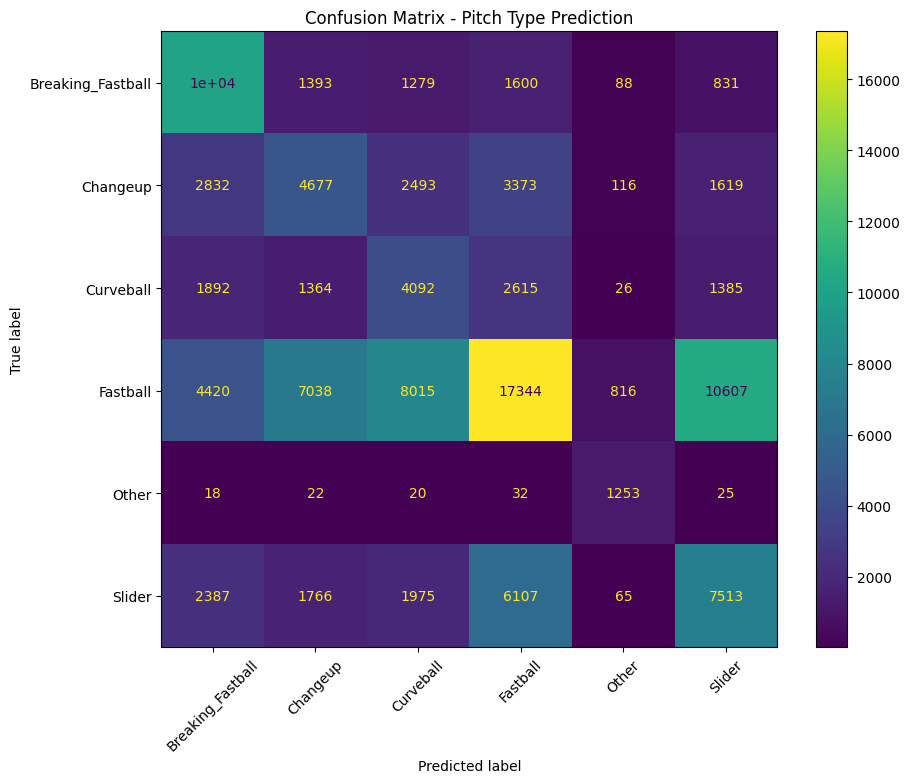

In [ ]:
cm6 = confusion_matrix(y_pitch_test, y_pred_classes6)


fig, ax = plt.subplots(figsize=(10, 8))

disp = ConfusionMatrixDisplay(confusion_matrix=cm6, display_labels=type_encoder.classes_)
disp.plot(ax=ax, xticks_rotation=45)

plt.title("Confusion Matrix - Pitch Type Prediction")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

cr6 = classification_report(y_pitch_test, y_pred_classes6, target_names=type_encoder.classes_)
print(cr6)

                   precision    recall  f1-score   support

Breaking_Fastball       0.47      0.66      0.55     15331
         Changeup       0.29      0.31      0.30     15110
        Curveball       0.23      0.36      0.28     11374
         Fastball       0.56      0.36      0.44     48240
            Other       0.53      0.91      0.67      1370
           Slider       0.34      0.38      0.36     19813

         accuracy                           0.40    111238
        macro avg       0.40      0.50      0.43    111238
     weighted avg       0.44      0.40      0.41    111238



# Construct LSTM Model for Pitch Type Prediction - Attempt #2

In this model, the LSTM layers are trained bi-directionally in an attempt to better understand patterns in the sequences.

In [ ]:
from tensorflow.keras.layers import Bidirectional

num_pitch_types = len(np.unique(y_pitch_train))

pitch_lstm_7 = models.Sequential([
    Bidirectional(layers.LSTM(64, activation = 'tanh', return_sequences=True, input_shape =(X_pitch_train.shape[1], 7))),
    Bidirectional(layers.LSTM(32, activation = 'tanh')),
    layers.Dense(num_pitch_types, activation= 'softmax')
])

pitch_lstm_7.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_pitch_train),
    y=y_pitch_train
)

class_weights = dict(enumerate(class_weights))


early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


history_pitch_lstm_7 = pitch_lstm_7.fit(
    X_pitch_train,
    y_pitch_train,
    epochs=100, batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weights,
    validation_split=0.2)

Epoch 1/100
11124/11124 ━━━━━━━━━━━━━━━━━━━━ 114s 10ms/step - accuracy: 0.2047 - loss: 1.6889 - val_accuracy: 0.2361 - val_loss: 1.6313
Epoch 2/100
11124/11124 ━━━━━━━━━━━━━━━━━━━━ 110s 10ms/step - accuracy: 0.2942 - loss: 1.4392 - val_accuracy: 0.2989 - val_loss: 1.5922
Epoch 3/100
11124/11124 ━━━━━━━━━━━━━━━━━━━━ 110s 10ms/step - accuracy: 0.3389 - loss: 1.3353 - val_accuracy: 0.2758 - val_loss: 1.5299
Epoch 4/100
11124/11124 ━━━━━━━━━━━━━━━━━━━━ 110s 10ms/step - accuracy: 0.3379 - loss: 1.3143 - val_accuracy: 0.3041 - val_loss: 1.4961
Epoch 5/100
11124/11124 ━━━━━━━━━━━━━━━━━━━━ 110s 10ms/step - accuracy: 0.3532 - loss: 1.2764 - val_accuracy: 0.3731 - val_loss: 1.4188
Epoch 6/100
11124/11124 ━━━━━━━━━━━━━━━━━━━━ 111s 10ms/step - accuracy: 0.3562 - loss: 1.2721 - val_accuracy: 0.4140 - val_loss: 1.3954
Epoch 7/100
11124/11124 ━━━━━━━━━━━━━━━━━━━━ 110s 10ms/step - accuracy: 0.3466 - loss: 1.2832 - val_accuracy: 0.3767 - val_loss: 1.4135
Epoch 8/100
11124/11124 ━━━━━━━━━━━━━━━━━━━━ 110

# Evaluation

Plot the training and validation loss

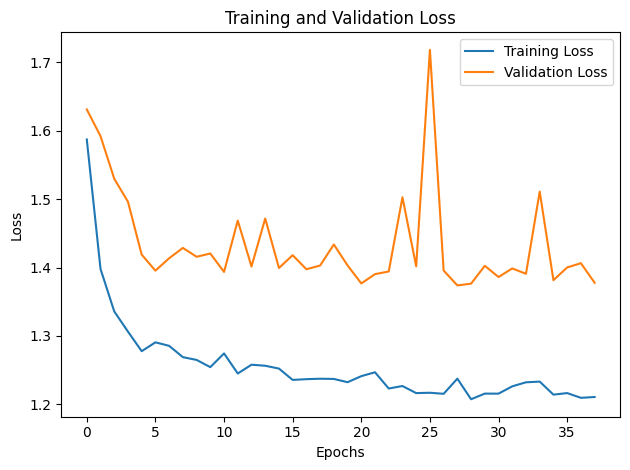

In [ ]:
plt.plot(history_pitch_lstm_7.history['loss'], label='Training Loss')
plt.plot(history_pitch_lstm_7.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

> There is some observable evidence of overfitting in the plot above. The training loss decreases at a faster rate than the validation loss, indicating that the model is learning from the training data but not generalizing as effectively to the validation set. While this overfitting does not appear to be severe enough to significantly harm the model’s effectiveness, it may have a slight negative impact on overall performance.

In [ ]:
y_pitch_pred_lstm7 = pitch_lstm_7.predict(X_pitch_test)

y_pred_classes7 = np.argmax(y_pitch_pred_lstm7, axis=1)
acc7 = accuracy_score(y_pitch_test, y_pred_classes7)
print(f"Accuracy: {acc7:.2f}")

3477/3477 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step
Accuracy: 0.40


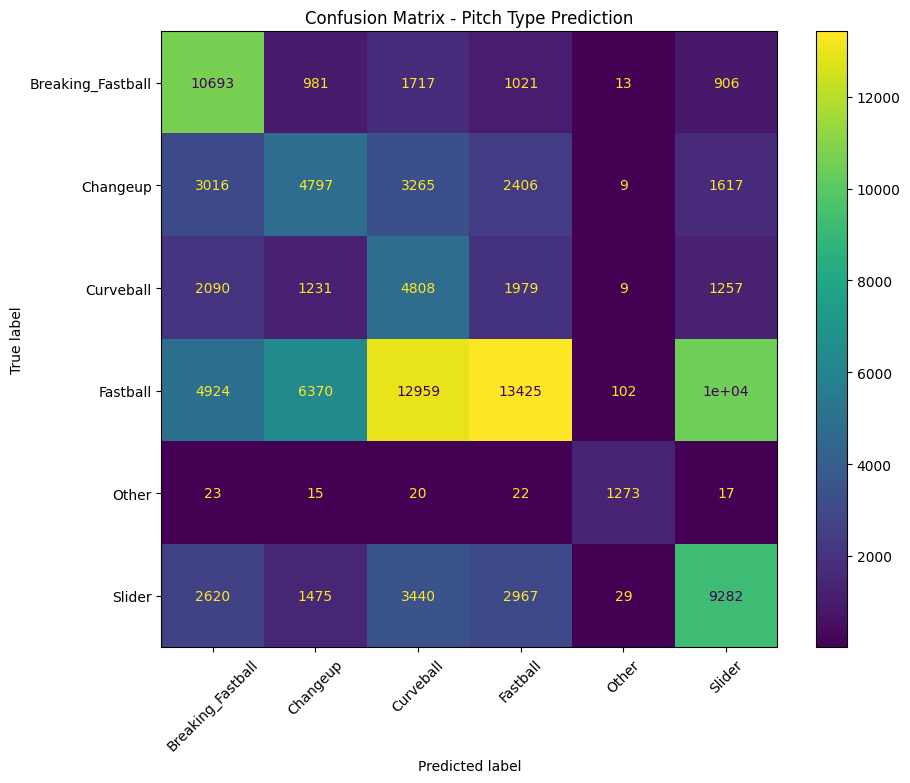

In [ ]:
cm7 = confusion_matrix(y_pitch_test, y_pred_classes7)


fig, ax = plt.subplots(figsize=(10, 8))

disp = ConfusionMatrixDisplay(confusion_matrix=cm7, display_labels=type_encoder.classes_)
disp.plot(ax=ax, xticks_rotation=45)

plt.title("Confusion Matrix - Pitch Type Prediction")
plt.show()

In [ ]:
cr7 = classification_report(y_pitch_test, y_pred_classes7, target_names=type_encoder.classes_)
print(cr7)

                   precision    recall  f1-score   support

Breaking_Fastball       0.46      0.70      0.55     15331
         Changeup       0.32      0.32      0.32     15110
        Curveball       0.18      0.42      0.26     11374
         Fastball       0.62      0.28      0.38     48240
            Other       0.89      0.93      0.91      1370
           Slider       0.39      0.47      0.43     19813

         accuracy                           0.40    111238
        macro avg       0.48      0.52      0.47    111238
     weighted avg       0.47      0.40      0.40    111238



# Overall Final Conclusions

> The nature of baseball, and pitching in particular, relies heavily on the art of deception. Pitchers intentionally make their pitch sequences difficult to predict, though not entirely stochastic. This inherent unpredictability makes it virtually impossible to construct a model that perfectly forecasts pitch selection for every pitch in a game. Fortunately, perfection is not the goal of this exercise. The aim is to build a model that can learn trends and patterns over the course of a full season much better than any human in the dugout could. I believe this model accomplishes that. With a final overall accuracy of 0.40 on the test set, a model like this could provide teams with a meaningful competitive advantage.

# Potential improvements

> 1 - Further protection from overfitting: In this model, early stop seemed to be helpful to prevent extreme overfitting. However, the loss plot indicates that there could be more to increase the generalizability of the model. Dropout did not seem to work too well, but L2 regularization or Ridge was not attempted. This could help adjust the weights of the features and allow the more impactful features to have more of an influence on the output.

> 2 - Fine tune the hyperparameters and test different activation functions. While tanh is the most common activation function used with LSTM models, it is not the only one. Sigmoid was not tested in this analysis. Sigmoid bounds all of the values between 0 and 1 as opposed to -1 and 1. I think it would be worth a shot to see how this would affect model performance.

> 3 - Feature Selection and Feature Engineering. Baseball is not played in a bubble, and previous experience does impact future outcomes. My input features do not include historical results from previous at-bats. This likely will have a huge impact on pitch selections. For example, if a batter hits a home run on a slider in the first inning, it’s likely that he will not be seeing the same pitch in the next at-bat. Integrating this kind of information would be very important to the model's performance.